## Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml
import warnings
warnings.filterwarnings('ignore')

In [71]:
with open ('trainfile_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Splits Data

In [72]:
df = pd.read_csv(config['training_file'])

In [73]:
#repleace the infinities with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [74]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,img_name,ThalamusDiameter,gestage,birthweight,BIIICss,BIIIRss,BIIIEss,Language Ability
0,0.000000,0.909091,0.269524,0.631531,1.625000,0.478382,0.611940,0.931239,0.920346,0.000000,...,0.776599,1.209950,P0006_morph1_0000000D.png,1.837605,280.0,3520.0,normal,abnormal,abnormal,abnormal
1,0.000000,1.470588,0.901686,2.306074,2.166667,0.745679,1.102564,1.480720,1.491054,1.000000,...,1.453139,1.159204,P0015_morph1_0000000A.png,1.886982,252.0,2750.0,normal,normal,normal,normal
2,0.083333,0.322917,0.062617,0.368451,0.263158,2.905412,0.495868,0.350758,0.277235,0.177778,...,0.191408,1.882688,P0020_morph1_00000001.png,1.921918,280.0,3175.0,normal,normal,normal,normal
3,0.000000,0.842105,0.185012,1.112407,0.764706,0.916183,0.714286,0.761554,1.327636,1.416667,...,1.817935,1.482688,P0020_morph1_00000002.png,1.700615,280.0,3175.0,normal,normal,normal,normal
4,0.000000,1.717949,0.966781,2.019003,1.823529,1.420889,1.986111,1.531226,2.517518,3.875000,...,7.107370,0.978049,P0020_morph1_00000003.png,1.806750,280.0,3175.0,normal,normal,normal,normal


In [75]:
df[config['target']]=df[config['target']].map({'normal': 0, 'abnormal': 1})
df[config['target']].value_counts()


BIIIEss
0    180
1     84
Name: count, dtype: int64

In [76]:
columns_to_drop = ['img_name', 'gestage', 'birthweight', 'Language Ability']
columns_to_drop = [col for col in columns_to_drop]
df.drop(columns=columns_to_drop, inplace=True)

In [77]:
df = df[df[config['target']].notna()]

To deal with imbalanced data

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [80]:
columns_to_drop = ['BIIICss', 'BIIIRss', 'BIIIEss']
columns_to_drop = [col for col in columns_to_drop]

X = df.drop(columns_to_drop, axis=1)
y = df[config['target']]
print(f'The target is {config["target"]}')

The target is BIIIEss


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
sm = SMOTE(random_state=42,k_neighbors=3)
# sampling_strategy=2 means that we want to have twice as many positive instances as negative instances
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Checking the new class distribution
print(f'Before SMOTE: {sum(y_train == 1)} positive instances and {sum(y_train == 0)} negative instances.')
print(f'After SMOTE: {sum(y_train_res == 1)} positive instances and {sum(y_train_res == 0)} negative instances.')


Before SMOTE: 69 positive instances and 142 negative instances.
After SMOTE: 142 positive instances and 142 negative instances.


In [82]:
X_train = X_train_res
y_train = y_train_res

In [83]:
# Scale the data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Model performance

In [84]:
def evaluate_model(model, scaled_X_test, y_test):
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_auc_score
    y_pred = model.predict(scaled_X_test);
    y_positive_prob = model.predict_proba(scaled_X_test)[:,1]; # Probability of positive class (label 1)
    
    #get confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
    
    #get classification report
    report = pd.DataFrame((classification_report(y_test, y_pred,output_dict=True))).transpose()
    print('\nClassification Report:\n', report)
    
    #calculate AUC
    auc_score = roc_auc_score(y_test, y_positive_prob)
    print(f"\nAUC socre is: {auc_score}\n")
    return y_pred,report,auc_score

In [85]:
def save_results(name,model,scaled_X_test,y_test,target = config['target'], feature_selection = config['feature_selection_method']):
    """ Save accuracy, precision,recall, f1 and auc to the model_scores list
    """
    from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score,precision_score
    y_pred = model.predict(scaled_X_test)
    y_prob = model.predict_proba(scaled_X_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    
    results = {
        'Target': target,
        'Feature Selection': feature_selection,
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }
    model_scores.append(results)


In [86]:
from sklearn.metrics import RocCurveDisplay

In [87]:
import os

# AutoGluon

In [88]:
# !pip install \
#    --no-binary lightgbm \
#    --config-settings=cmake.define.USE_OPENMP=OFF \
#    'lightgbm>=4.0.0'

In [89]:
#!python -m pip install autogluon

In [90]:
train_df['ThalamusDiameter']

0      1.461010
1      2.324490
2      1.803995
3      1.869120
4      1.758776
         ...   
253    1.818233
254    1.466549
255    1.993957
256    1.753698
257    1.534114
Name: ThalamusDiameter, Length: 258, dtype: float64

In [91]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [92]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [93]:
label =config['target']
predictor = TabularPredictor(label=label).fit(train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20240521_133810"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240521_133810"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 

In [94]:
y_pred = predictor.predict(test_df)

In [95]:
predictor.evaluate(test_df)

{'accuracy': 0.5471698113207547,
 'balanced_accuracy': 0.48245614035087714,
 'mcc': -0.03295917321500787,
 'roc_auc': 0.5140350877192982,
 'f1': 0.29411764705882354,
 'precision': 0.2631578947368421,
 'recall': 0.3333333333333333}

In [96]:
autogluon_result = predictor.leaderboard(test_df, extra_metrics=['precision','recall','f1','roc_auc'])

In [97]:
autogluon_result = autogluon_result.iloc[:,0:9]
autogluon_result

,model,score_test,precision,recall,f1,roc_auc,score_val,eval_metric,pred_time_test
0,NeuralNetFastAI,0.735849,0.538462,0.466667,0.500000,0.642105,0.771930,accuracy,0.005078
1,LightGBMLarge,0.679245,0.444444,0.533333,0.484848,0.607018,0.824561,accuracy,0.005093
2,XGBoost,0.660377,0.421053,0.533333,0.470588,0.592982,0.824561,accuracy,0.003405
3,RandomForestGini,0.641509,0.388889,0.466667,0.424242,0.587719,0.789474,accuracy,0.019920
4,LightGBM,0.603774,0.384615,0.666667,0.487805,0.598246,0.824561,accuracy,0.000888
5,NeuralNetTorch,0.566038,0.277778,0.333333,0.303030,0.561404,0.807018,accuracy,0.010882
6,ExtraTreesEntr,0.566038,0.300000,0.400000,0.342857,0.534211,0.807018,accuracy,0.015890
7,LightGBMXT,0.547170,0.263158,0.333333,0.294118,0.514035,0.842105,accuracy,0.002142
8,WeightedEnsemble_L2,0.547170,0.263158,0.333333,0.294118,0.514035,0.842105,accuracy,0.002724
9,ExtraTreesGini,0.547170,0.235294,0.266667,0.250000,0.538596,0.807018,accuracy,0.015982


In [98]:
#save AutoGluon results to excel
autogluon_result.to_excel(os.path.join(config['output_dir']+'_'+config['target']+'AutoG'+'.xlsx'), index=False)

These features in provided data are not utilized by the predictor and will be ignored: ['original_firstorder_TotalEnergy']
Computing feature importance via permutation shuffling for 86 features using 284 rows with 5 shuffle sets...
	8.41s	= Expected runtime (1.68s per shuffle set)
	2.45s	= Actual runtime (Completed 5 of 5 shuffle sets)


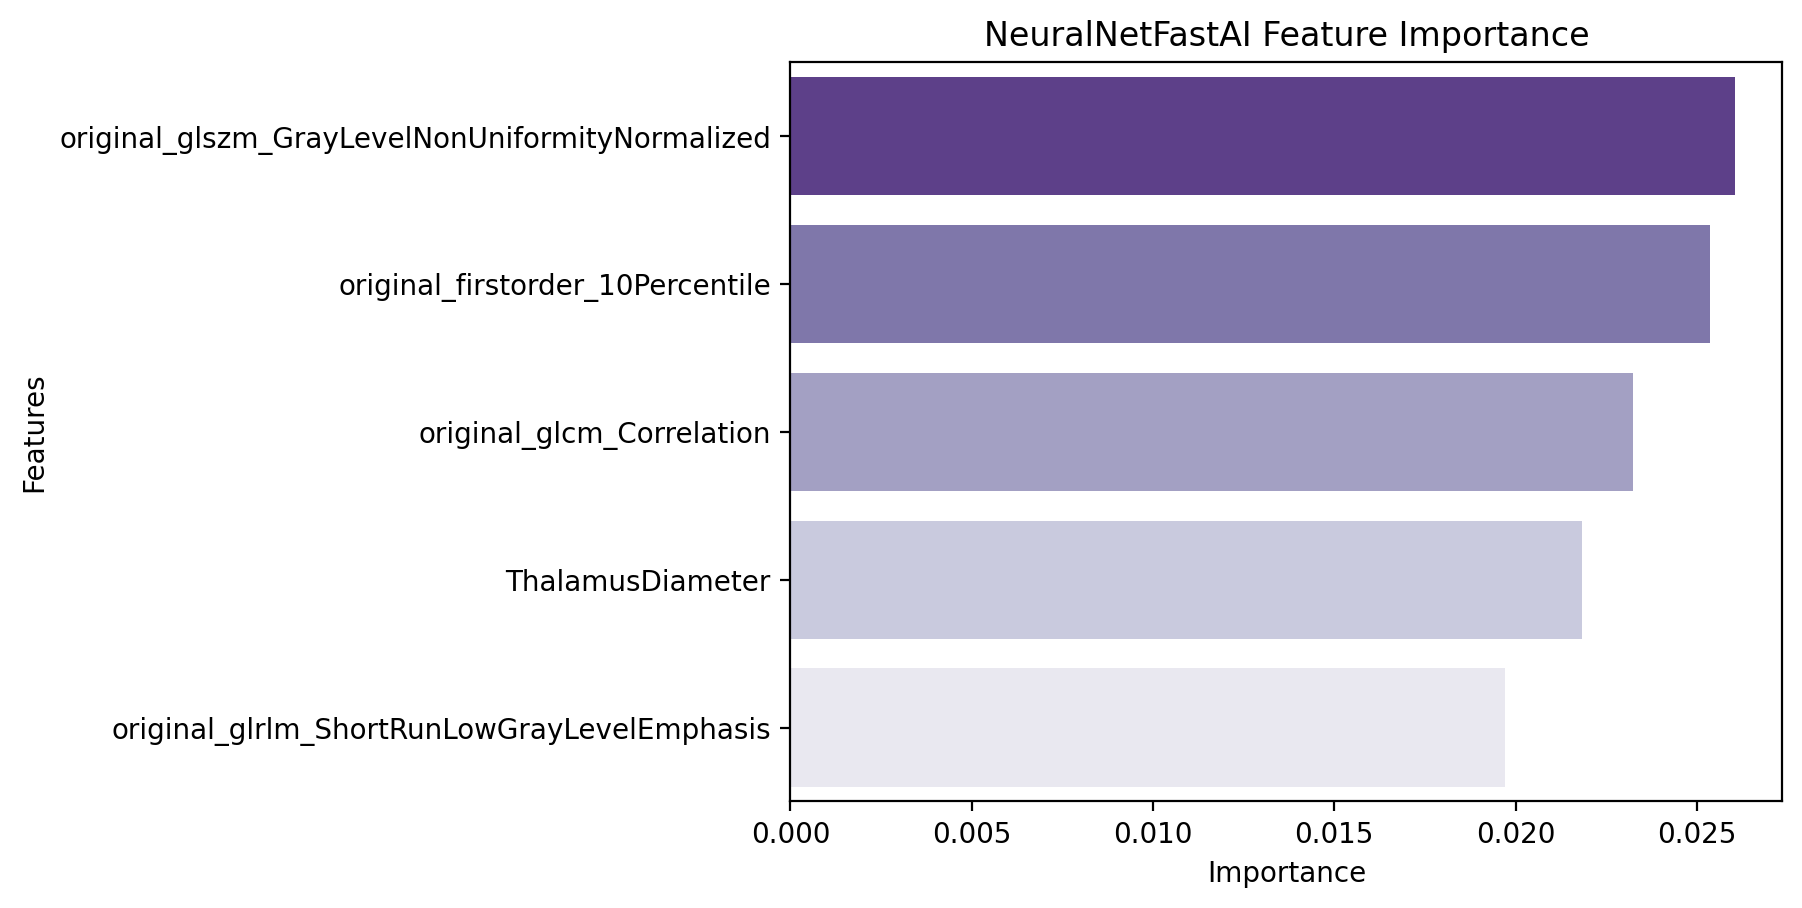

In [99]:
gluon_model = 'NeuralNetFastAI'
feature_importance = predictor.feature_importance(data=train_df, model=gluon_model)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.nlargest(5,'importance')
plt.figure(dpi=200)
sns.barplot(x=feature_importance['importance'], y=feature_importance.index,palette='Purples_r')
plt.title(f'{gluon_model} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

These features in provided data are not utilized by the predictor and will be ignored: ['original_firstorder_TotalEnergy']
Computing feature importance via permutation shuffling for 86 features using 284 rows with 5 shuffle sets...
	6.6s	= Expected runtime (1.32s per shuffle set)
	2.26s	= Actual runtime (Completed 5 of 5 shuffle sets)


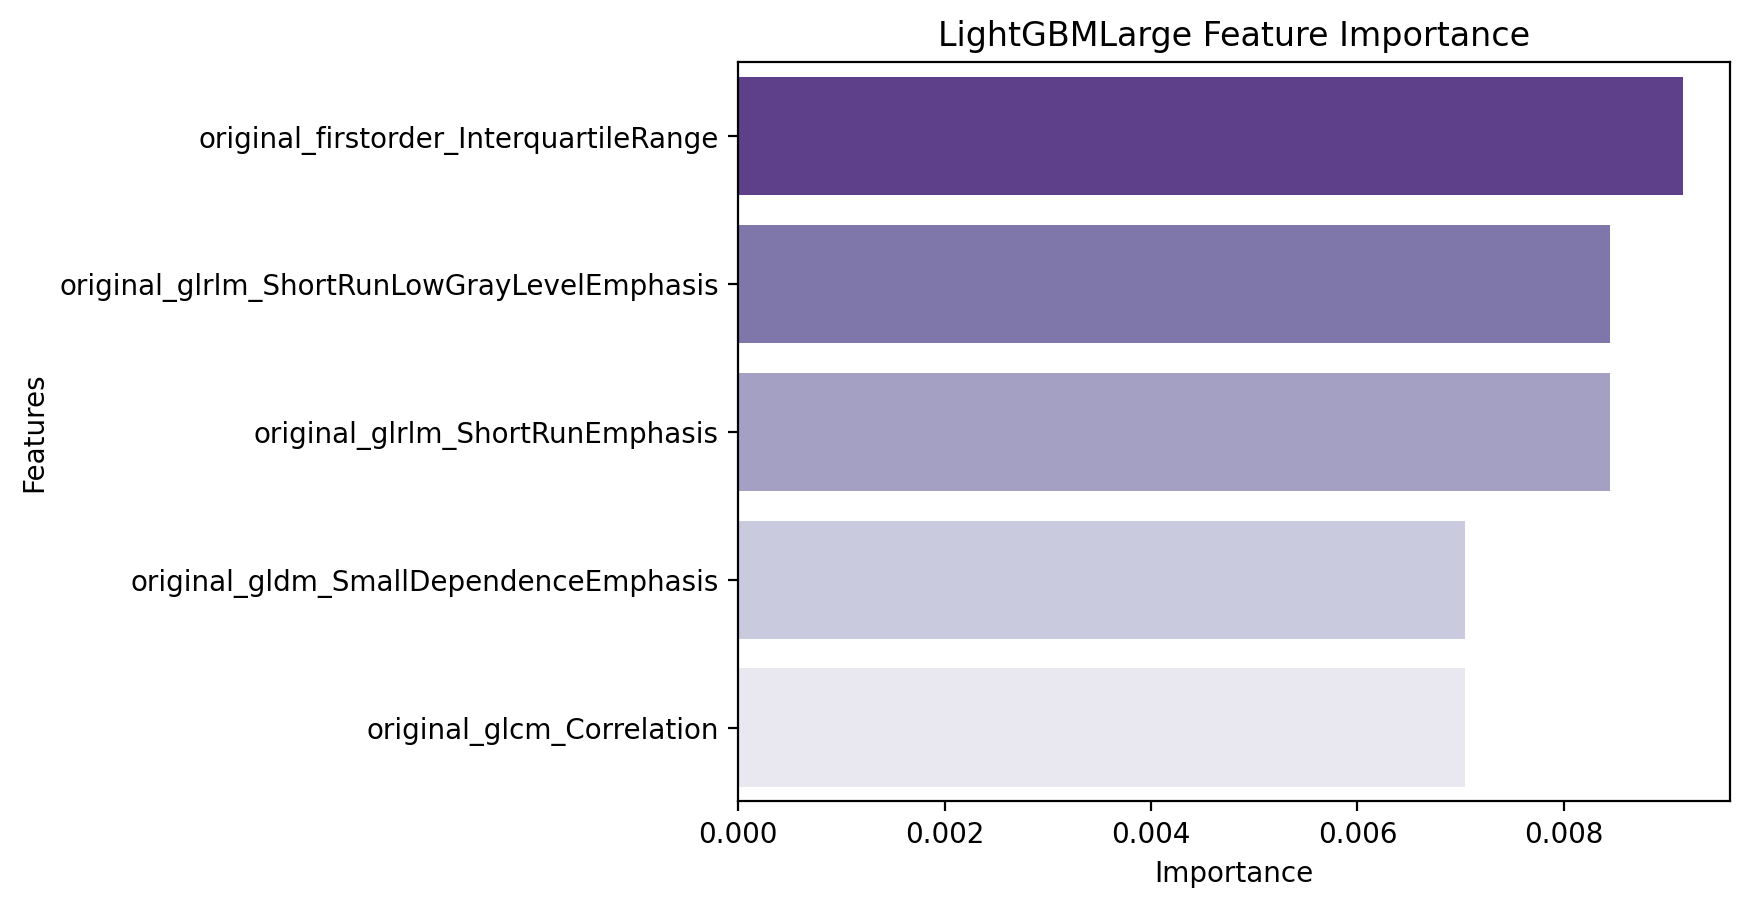

In [100]:
gluon_model = 'LightGBMLarge'

feature_importance = predictor.feature_importance(data=train_df, model=gluon_model)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.nlargest(5,'importance')
plt.figure(dpi=200)
sns.barplot(x=feature_importance['importance'], y=feature_importance.index,palette='Purples_r')
plt.title(f'{gluon_model} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()